In [1]:
# example code for plotting stuff form a .txt file
import numpy as np
import matplotlib.pyplot as plt 
import os
import re

from numba import njit, jit
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit



def exponential_decay(lag, tau, A):
    return A * np.exp(-lag / tau)

# velocity during running 
v_0_run = 20 # micrometers / s

In [3]:
# drift speed v_D as a function of gradient for one value of c_0


# rootdir in the form of data_with_metnoise/data_without_metnoisse
# subdirectories : c0=0.1, c0=1, c0=10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5
 
# in each g-directory 120 Main_output_#.txt files from running main.py
 

rootdir = ".../code/changing_g_no_metnoise_700s-5ms-v20/c0_10"
dirnames = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dir = len(dirnames)
gradient_g = []
v_d_list = []
pos_x_list = []
v_x_list= []

for dir_name in dirnames:
    print(dir_name)
    
    match = re.search(r'g([0-9.]+)', dir_name)
    if match:
        g_value = float(match.group(1))
        gradient_g.append(g_value)
    
    data_dir = os.path.join(rootdir, dir_name)
    

    if os.path.isdir(data_dir): # make sure that data_dir is a directory otherwise it skips it
        num_files = len(os.listdir(data_dir)) -3
          #subtracting from the count the nohup.out file
        print(num_files)
        for i in range(num_files):
            file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
        
            # Load the entire file as a 1D array
            data = np.loadtxt(file_path)

            num_points= int(data[0]) # this is the same for all files or should be (maybe add a check so you collect the value
            #  for each directory and make sure they are all the same and if they are not boh)
            
            v_d_list.append(data[1]) # the drift velocity of the i trajectory is the first data points in the file txt
            pos_x_list.append(data[2:num_points+3])
            v_x_list.append(data[num_points+3:])

print('gradients: ', gradient_g)

# singular scalar for each file --> 2D matrix
v_d_toreshape = np.array([v_d_list])
print(len(v_d_list))
v_d = v_d_toreshape.reshape(num_dir, num_files).transpose(1,0)



# multiple scalars for each file --> 3D matrix


var_v_d = np.var(v_d, axis=0) / num_files # dividing by N (number of indipendent variables) to get the standard error

print(f'variance: {var_v_d}, std: {np.sqrt(var_v_d)}, mean: {np.mean(v_d,axis=0)}')

# Split into two vectors
mean_v = np.mean(v_d,axis=0)
std_v = np.sqrt(var_v_d)



 

g0.1
103
g0.2
103
g0.3
103
g0.5
103
g1
103
g2
103
g0
103
gradients:  [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 0.0]
721
variance: [0.01247924 0.00450541 0.00149855 0.00070263 0.00027715 0.00036187
 0.01779328], std: [0.11171051 0.06712237 0.03871114 0.02650717 0.01664787 0.019023
 0.13339145], mean: [3.19741837 4.12898695 3.20640918 1.81194486 0.78613233 0.14040643
 0.16209283]


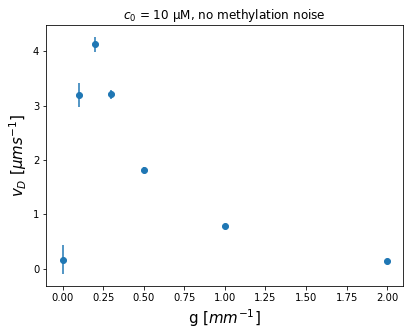

In [5]:
# plotting drift speed as a function of gradient

plt.figure(figsize=(6.4, 4.8))

plt.errorbar(gradient_g, mean_v, yerr= 2*std_v, fmt='o', linestyle='none')
#plt.title('With methylation noise')
plt.title(r'$c_0$ = 10 μM, no methylation noise')
plt.xlabel(r'g [$mm^{-1}$]', fontsize = 15)
plt.ylabel(r'$v_D$ $[μms^{-1}]$', fontsize = 15)
#plt.ylim([-0.1, 0.15])
#plt.legend()
plt.show()

In [6]:

print(len(pos_x_list))
print(len(v_x_list))
# multiple scalars for each file --> 3D matrix
 
#print(pos_x_list.shape)
pos_x_toreshape = np.array(pos_x_list)

# pos_x has an additional point/dimension with respect to v_x
pos_x = pos_x_toreshape.T # 3d matrix
print(pos_x.shape)
pos_x= pos_x.reshape(num_points+1, num_dir, num_files).transpose(0, 2, 1)


v_x_toreshape = np.array(v_x_list)
v_x = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
v_x = v_x.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)



721
721
(140002, 721)


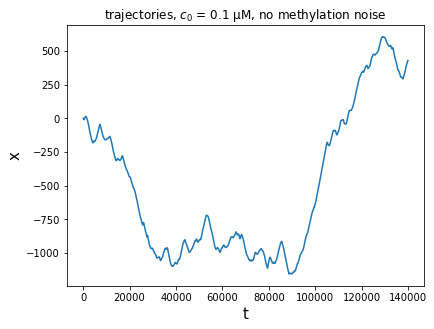

In [7]:
# plotting one trajectory

plt.figure(figsize=(6.4, 4.8))

plt.plot(np.arange(0, num_points+1),pos_x[:,27,6])

#plt.title('With methylation noise')
plt.title(r'trajectories, $c_0$ = 0.1 μM, no methylation noise')
plt.xlabel(r't', fontsize = 15)
plt.ylabel(r'x', fontsize = 15)
#plt.ylim([-0.1, 0.15])
#plt.legend()
plt.show()

(1, 7)
(140001, 103)
(4001,)
(140001, 103)
(4001,)
(140001, 103)
(4001,)
(140001, 103)
(4001,)
(140001, 103)
(4001,)
(140001, 103)
(4001,)


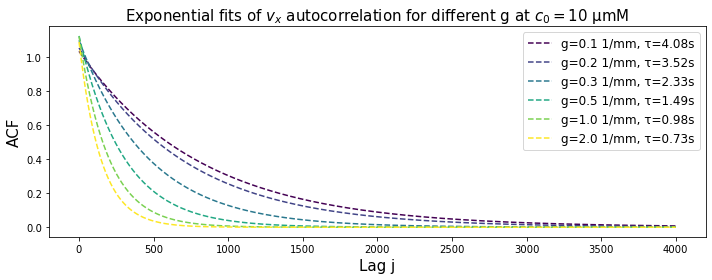

In [120]:
# Autocorrelation of v_x

gradient_g1 = np.array([gradient_g])
print(gradient_g1.shape)
plt.figure(figsize=(10, 4))  # Create a single figure for all plots

colors = plt.cm.viridis(np.linspace(0, 1, 6))   # Unique color per curve
tau_list = []

for g_index in range(0,6):
    
    v_x_bin = v_x[:, :, g_index]  # Shape: (time_points, N_trajectories)
    print(v_x_bin.shape)
    acf_matrix = []

    for i in range(v_x_bin.shape[1]):
        column_data = v_x_bin[:, i]
        acf_values = acf(
            column_data,
            adjusted=True,
            nlags=4000,
            qstat=False,
            fft=True,
            alpha=None,
            bartlett_confint=True,
            missing='none'
        )
        acf_matrix.append(acf_values)

    acf_matrix = np.array(acf_matrix).T
    acf_mean = np.mean(acf_matrix, axis=1)
    print(acf_mean.shape)

    lags = np.arange(len(acf_mean))

    # Fit exponential decay
    try:
        params, _ = curve_fit(exponential_decay, lags, acf_mean, p0=[5, 1])
        tau_autocorr = params[0]
        tau_list.append(tau_autocorr)
        dt_autoc = tau_autocorr*dt_model

        # Plot ACF
        #plt.plot(lags, acf_mean, marker='o', linestyle='-', color=colors[idx], label=f"g={gradient_g[:, g_index][0]}mm-1, τ={dt_autoc:.2f}s")
        # Plot fit
        gg = gradient_g1[:, g_index][0]
        plt.plot(lags, exponential_decay(lags, *params), linestyle='--', color=colors[g_index], label=f"g={gg} 1/mm, τ={dt_autoc:.2f}s")
    except RuntimeError:
        print(f"Fit failed for g_index {g_index}")
        continue

# Final plot formatting
plt.xlabel("Lag j", fontsize=15)
plt.ylabel("ACF",fontsize=15)
plt.title(r"Exponential fits of $v_x$ autocorrelation for different g at $c_0 = 10$ μM", fontsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

c0_0.1
g0.1
120
g0.2
120
g0.3
120
g0.5
120
g1
120
g2
120
g0
120
gradients:  [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 0.0]
[ 0.05991878 -0.00465498]
c0_1
g0.1
120
g0.2
120
g0.3
120
g0.5
120
g1
120
g2
120
g0
120
gradients:  [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 0.0]
[0.2745267  0.00510266]
c0_10
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
g1
120
g2
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0]
[1.03177102 0.01885057]


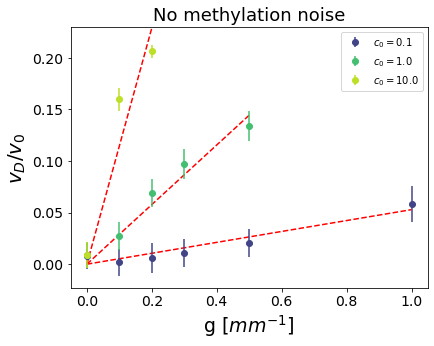

In [5]:
# drift speed v_D as a function of gradient and c_0



# rootdir in the form of data_with_metnoise/data_without_metnoisse
# subdirectories : c0=0.1, c0=1, c0=10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5
 
# in each g-directory 120 Main_output_#.txt files from running main.py
 

colors = plt.cm.viridis([0.2, 0.7, 0.9]) 
conc = np.array([0.1, 1, 10])

rootdir = "/home/ipausers/sauro/code/changing_g_no_metnoise_700s-5ms-v20"
dircmain = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dirc = len(dircmain)

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)
pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
c0_order = []

# TO FIX automize the read and order of the values depending on the c0 folder readout
cc = np.array([2,1,4])# np.array([1, 2, 4])
plt.figure(figsize=(6.4, 4.8))

for dirc in dircmain:
    print(dirc)
    match0 = re.search(r'c0_([0-9.]+)', dirc)
    if match0:
        c_value = float(match0.group(1))
        c0_order.append(c_value)
    if c_value == 0.1: cc[count_dir] = 1
    if c_value == 1: cc[count_dir] = 2
    if c_value == 10: cc[count_dir] = 4

    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    gradient_g = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'g([0-9.]+)', dir_name)
            if match:
                g_value = float(match.group(1))
                gradient_g.append(g_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+3])
                    v_x_list.append(data[num_points+3:])

        print('gradients: ', gradient_g)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points+1, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir] / v_0_run
        x = np.array(gradient_g)
        err = std_v[count_dir] / v_0_run
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices][0:(len(gradient_g)-cc[count_dir])]
        y_sorted_with0 = np.concatenate(([0], y_sorted[1:]))

        x_sorted = x[sorted_indices][0:(len(gradient_g)-cc[count_dir])]
        err_sorted = err[sorted_indices][0:(len(gradient_g)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted_with0, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)
        # Fit a line through the origin: y = m * x
        m_slope = np.sum(x_sorted * y_sorted) / np.sum(x_sorted**2)

        # Create the fitted line
        y_fit = m_slope * x_sorted

        # plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)
        plt.plot(x_sorted, y_fit, '--r')  # red dashed line (fit only)

        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            color=colors[count_dir],
            label=f"$c_0 = {c_value}$"
        )

        count_dir += 1

plt.title(r'No methylation noise', fontsize=18)
plt.xlabel(r'g [$mm^{-1}$]', fontsize=19)
plt.ylabel(r'$v_D/v_0$ ', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(top = 0.23)
plt.legend()
plt.show()


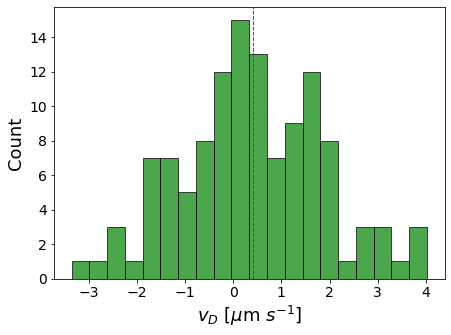

In [7]:
# histogram of v_D for a selected c0 and g

# looking at c0=1 and g=0.3
drift_speed_array = v_d[0][:,3]

plt.figure(figsize=(7, 5))  # Wider for better label spacing
plt.hist(drift_speed_array, bins=20, color='g', edgecolor='black', alpha=0.7)
plt.axvline(x= mean_v[0][3], color='r', linestyle='--', linewidth=1)
plt.xlabel(r'$v_D$ [$\mu$m $s^{-1}$]', fontsize=18)
plt.ylabel('Count', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
 
  # Avoid label clipping
plt.show()

[[0.  0.1 0.2 0.3 0.5 1.  2. ]]
(140001, 120)
(5501,)
$c_0$ = 0.1, g=0.0, τ=5.60s
(140001, 120)
(5501,)
$c_0$ = 1.0, g=0.0, τ=5.40s
(140001, 120)
(5501,)
$c_0$ = 10.0, g=0.0, τ=5.46s


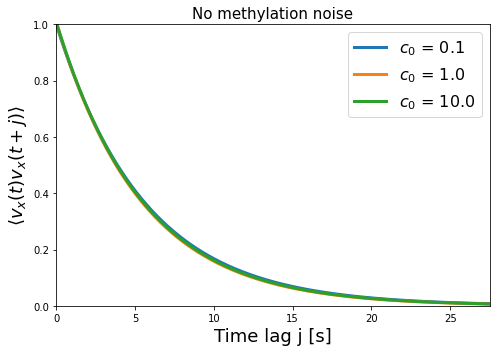

In [12]:
# Autocorrelation of v_x with changing c_0 as well

# MAKE SURE TO RUN PREVIOUS CELL TO GET THE CORRECT DATA

dt_model = 5 * 10**(-3)
gradient_g1 = np.array([gradient_g])
print(gradient_g1)
plt.figure(figsize=(7, 5))  # Create a single figure for all plots

colors = plt.cm.tab10([0,1,2])   # Unique color per curve
tau_list = []
color_index = 0
for c_index in range(0,3):
    # for g_index in range(1,2):

        g_index = 0
        v_x_bin = v_x[c_index][:, :, g_index]  # Shape: (time_points, N_trajectories)
        print(v_x_bin.shape)
        acf_matrix = []

        for i in range(v_x_bin.shape[1]):
            column_data = v_x_bin[:, i]
            acf_values = acf(
                column_data,
                adjusted=True,
                nlags=5500,
                qstat=False,
                fft=True,
                alpha=None,
                bartlett_confint=True,
                missing='none'
            )
            acf_matrix.append(acf_values)

        acf_matrix = np.array(acf_matrix).T
        acf_mean = np.mean(acf_matrix, axis=1)
        print(acf_mean.shape)

        lags = np.arange(len(acf_mean))

        # Fit exponential decay
        try:
            params, _ = curve_fit(exponential_decay, lags, acf_mean, p0=[5, 1])
            tau_autocorr = params[0]
            tau_list.append(tau_autocorr)
            dt_autoc = tau_autocorr*dt_model

            # Plot ACF
            #plt.plot(lags, acf_mean, marker='o', linestyle='-', color=colors[idx], label=f"g={gradient_g[:, g_index][0]}mm-1, τ={dt_autoc:.2f}s")
            # Plot fit
            gg = gradient_g1[:, g_index][0]
            plt.plot(lags*dt_model, exponential_decay(lags, *params), linestyle='-', linewidth=3.0, color=colors[color_index], label=f"$c_0$ = {conc[c_index]}")
            color_index += 1
            print(f'$c_0$ = {conc[c_index]}, g={gg}, τ={dt_autoc:.2f}s')
        except RuntimeError:
            print(f"Fit failed for g_index {g_index}")
            continue

# Final plot formatting
plt.xlabel("Time lag j [s]", fontsize=18)
plt.ylabel(r"$\langle v_x(t)v_x(t+j) \rangle $",fontsize=20)
#plt.title(r"With methylation noise", fontsize=15)
plt.xlim([0, max(lags*dt_model)])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

7
[ 0.1  1.  10. ]
3
[0.  0.1 0.2 0.3 0.5 1.  2. ]
[0.  0.1 0.2 0.3 0.5 1.  2. ]
[0.  0.1 0.2 0.3 0.5 1.  2. ]


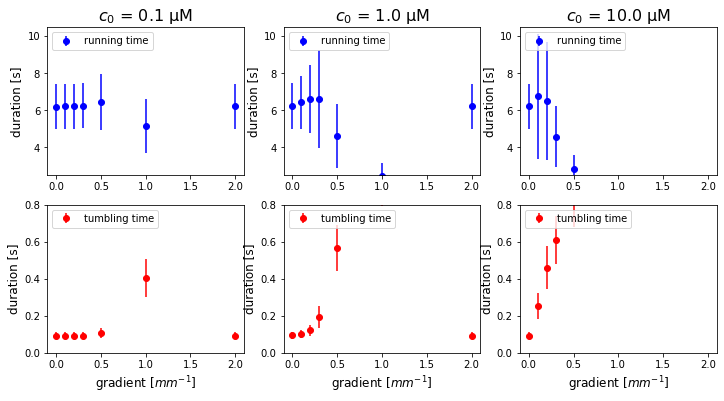

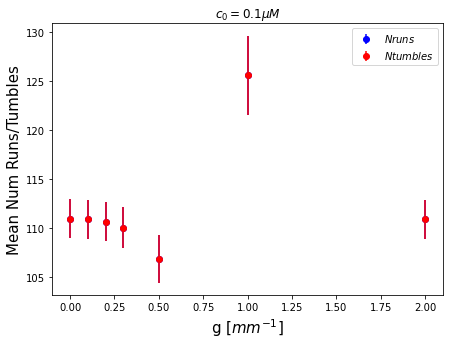

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


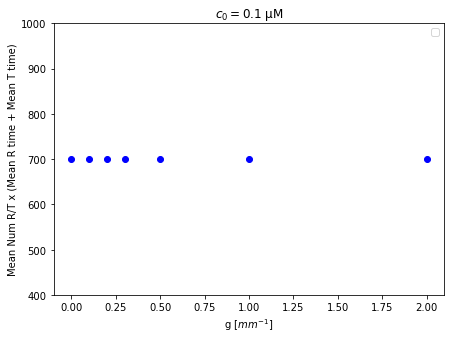

In [8]:
# average run and tumble duration case with no methylation noise



c0_order_array = np.array(c0_order)
indices_c0_order_sorted = np.argsort(c0_order_array)

#v_x_sorted = v_x[indices_c0_order_sorted]

gradient_g = np.array(gradient_g)
idx_g_sorted = np.argsort((gradient_g))
gradient_g2 = np.array(gradient_g) # gradient_g[idx_g_sorted]
lenght_g_array = len(gradient_g2)
print(lenght_g_array)



conc1 = c0_order_array #[indices_c0_order_sorted]
print(conc1)
count_dir = 0
cc = np.array([0,0,0]) # np.array([1, 2, 4])
dt_model = 0.005  # seconds

N_conc = len(conc1)
print(N_conc)
c_idx1 = 1
# Number of trajectories for each g
N_traj = v_x[c_idx1].shape[1]
# Number of subplots
N_grad = v_x[c_idx1].shape[2]

N_runs = np.empty(N_conc, dtype=object)
N_tumbles = np.empty(N_conc, dtype=object)

mean_run_time = np.zeros((N_conc, N_grad))
mean_tumble_time = np.zeros((N_conc, N_grad))

std_run_time = np.zeros((N_conc, N_grad))
std_tumble_time = np.zeros((N_conc, N_grad))


fig, axes = plt.subplots(2, N_conc, figsize=(12, 3 *2))
axes = np.reshape(axes, (2, N_conc))

for c_idx in range(N_conc):
    N_runs[c_idx] = np.zeros((N_traj, N_grad))
    N_tumbles[c_idx] = np.zeros((N_traj, N_grad))

    #v_x_sorted_sorted = v_x_sorted[c_idx][:,:,idx_g_sorted]

    for g_idx in range(N_grad):
        array_tumbles = []
        array_runs = []
        var_run_traj_i = []
        var_tumble_traj_i = []

        for traj_idx in range(N_traj):
            zero_count = 0
            non_zero_count = 0
            array_tumbles_traj_i = []
            array_runs_traj_i = []

            for i in v_x[c_idx][:, traj_idx, g_idx]:# v_x_sorted_sorted[:, traj_idx, g_idx]:

                if i == 0:
                    zero_count += 1
                    if non_zero_count > 0:
                        array_runs.append(non_zero_count)
                        array_runs_traj_i.append(non_zero_count)
                        non_zero_count = 0
                else:
                    non_zero_count += 1
                    if zero_count > 0:
                        array_tumbles.append(zero_count)
                        array_tumbles_traj_i.append(zero_count)
                        zero_count = 0

            if zero_count > 0:
                array_tumbles.append(zero_count)
                array_tumbles_traj_i.append(zero_count)
            if non_zero_count > 0:
                array_runs.append(non_zero_count)
                array_runs_traj_i.append(non_zero_count)

            N_runs[c_idx][traj_idx, g_idx] = len(np.array(array_runs_traj_i))
            N_tumbles[c_idx][traj_idx, g_idx] = len(np.array(array_tumbles_traj_i))

            if N_runs[c_idx][traj_idx, g_idx] - N_tumbles[c_idx][traj_idx, g_idx] != 0:
                if N_runs[c_idx][traj_idx, g_idx] - N_tumbles[c_idx][traj_idx, g_idx] != 1: print('bro smt wrong')
                N_tumbles[c_idx][traj_idx, g_idx] += 1
                array_tumbles.append(1)
                array_tumbles_traj_i.append(1)

            running_times_traj_i = np.array(array_runs_traj_i) * dt_model
            tumbling_times_traj_i = np.array(array_tumbles_traj_i) * dt_model

            var_run_traj_i.append(np.var(running_times_traj_i)/len(running_times_traj_i))
            var_tumble_traj_i.append(np.var(tumbling_times_traj_i)/len(tumbling_times_traj_i))

        var_run_time = np.mean(var_run_traj_i)
        var_tumble_time = np.mean(var_tumble_traj_i)

        tumble_times = np.array(array_tumbles) * dt_model
        run_times = np.array(array_runs) * dt_model

        mean_run_time[c_idx, g_idx] = np.mean(run_times)
        std_run_time[c_idx, g_idx] = np.sqrt(var_run_time)

        mean_tumble_time[c_idx, g_idx] = np.mean(tumble_times)
        std_tumble_time[c_idx, g_idx] = np.sqrt(var_tumble_time)

    axes[0, c_idx].errorbar(
            gradient_g2[0:(lenght_g_array-cc[count_dir])],
            mean_run_time[c_idx, 0:(lenght_g_array-cc[count_dir])],
            yerr=2 * std_run_time[c_idx, 0:(lenght_g_array-cc[count_dir])], 
            fmt='o',
            linestyle='none',
            color='b',
            label=f"running time"
        )
    axes[0, c_idx].set_ylabel('duration [s]', fontsize=12)
    axes[0, c_idx].set_title(f"$c_0$ = {conc1[c_idx]} μM", fontsize=16)
    axes[0, c_idx].set_ylim([2.5,10.5])
    axes[0, c_idx].legend(loc='upper left')

    axes[1, c_idx].errorbar(
            gradient_g2[0:(lenght_g_array-cc[count_dir])],
            mean_tumble_time[c_idx, 0:(lenght_g_array-cc[count_dir])],
            yerr=2 * std_tumble_time[c_idx, 0:(lenght_g_array-cc[count_dir])], 
            fmt='o',
            linestyle='none',
            color='r',
            label=f"tumbling time"
        )
    axes[1, c_idx].set_xlabel(r'gradient [$mm^{-1}$]', fontsize=12)
    axes[1, c_idx].set_ylabel('duration [s]', fontsize=12)
    axes[1, c_idx].set_ylim([0,0.8])
    axes[1, c_idx].legend(loc='upper left')
    

    print(gradient_g2[0:(lenght_g_array-cc[count_dir])])

    count_dir += 1
plt.show()


c_index_plt = 0
mean_N_runs = np.mean(N_runs[c_index_plt], axis = 0)
std_N_runs = np.sqrt(np.var(N_runs[c_index_plt], axis = 0) / N_traj)
mean_N_tumbles = np.mean(N_tumbles[c_index_plt], axis = 0)
std_N_tumbles = np.sqrt(np.var(N_tumbles[c_index_plt], axis = 0) / N_traj)

plt.figure(figsize=(7, 5))

plt.errorbar(gradient_g2, mean_N_runs, yerr= 2* std_N_runs, fmt='o',
            linestyle='none',
            color='b',
            label=f"$N  runs$"
        )
plt.errorbar(gradient_g2, mean_N_tumbles, yerr= 2* std_N_tumbles, fmt='o',
            linestyle='none',
            color='r',
            label=f"$N tumbles$"
        )
plt.title(f'$c_0 = {conc1[c_index_plt]} μM$')
plt.ylabel(r'Mean Num Runs/Tumbles', fontsize=15)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=15)
plt.legend()
plt.show()

 
sum_to_verify = mean_N_runs * mean_run_time[c_index_plt, :].flatten() + mean_N_tumbles * mean_tumble_time[c_index_plt, :].flatten()
#err_sum = 

plt.figure(figsize=(7, 5))

plt.errorbar(gradient_g2, sum_to_verify, yerr= 2* 0, fmt='o',
            linestyle='none',
            color='b'#,
            #label=f"$N  runs$"
        )

plt.title(f'$c_0 = {conc1[c_index_plt]}$ μM')
plt.ylabel(r'Mean Num R/T x (Mean R time + Mean T time)', fontsize=10)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=10)
plt.ylim([400, 1000])
plt.legend()
plt.show()



c0_1_no_metnoise
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5]
[0.27018268 0.00214948]
c0_1_w_metnoise
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5]
[ 0.25777991 -0.01166003]
c0_1_w_metnoise_x2
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5]
[ 0.21484791 -0.0042147 ]
c0_1_w_metnoise_x10
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5]
[ 0.12109619 -0.0050131 ]


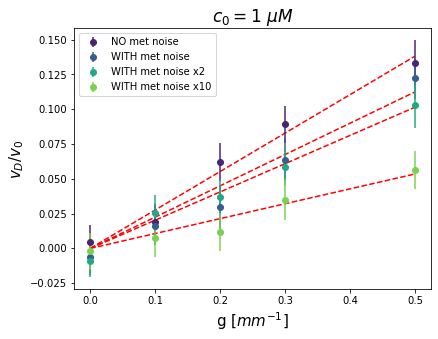

In [2]:
# Plotting for c0=1 drift speed as a function of gradient and increasing methylation noise




colors = plt.cm.viridis([0.1, 0.3, 0.6, 0.8]) 



# rootdir in the form of data_with&without_metnoisse
# subdirectories : no_metnoise, w_metnoise, w_metnoisex2, w_metnoisex10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5
 
# in each g-directory 120 Main_output_#.txt files from running main.py
 

rootdir = "../code/c0_1_no&w_metnoise"
dircmain = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dirc = len(dircmain)

label_dir = ["NO met noise", "WITH met noise", "WITH met noise x2", "WITH met noise x10" ]

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)
pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
cc = np.array([0,0,0,0])# np.array([1, 2, 4])
plt.figure(figsize=(6.4, 4.8))

for dirc, dir_label in zip(dircmain, label_dir):
    print(dirc)
    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    gradient_g = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'g([0-9.]+)', dir_name)
            if match:
                g_value = float(match.group(1))
                gradient_g.append(g_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+2])
                    v_x_list.append(data[num_points+2:])

        print('gradients: ', gradient_g)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points-1, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir] / v_0_run 
        x = np.array(gradient_g)
        err = std_v[count_dir] / v_0_run 
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]

        x_sorted = x[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        err_sorted = err[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)
        # Fit a line through the origin: y = m * x
        m_slope = np.sum(x_sorted * y_sorted) / np.sum(x_sorted**2)

        # Create the fitted line
        y_fit = m_slope * x_sorted

        # plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)
        plt.plot(x_sorted, y_fit, '--r')  # red dashed line (fit only)


        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            color=colors[count_dir],
            label=dir_label
        )

        count_dir += 1

plt.title(r'$c_0 = 1\ \mu M$', fontsize=17)
plt.xlabel(r'g [$mm^{-1}$]', fontsize=15)
plt.ylabel(r'$v_D / v_0$ ', fontsize=15) # $[\mu m s^{-1}]$', fontsize=15)
plt.legend()
plt.show()


c0_0.1
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
g1
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5, 1.0]
[0.02516416 0.00154903]
c0_1
g0
120
g0.1
120
g0.2
120
g0.3
120
g0.5
120
gradients:  [0.0, 0.1, 0.2, 0.3, 0.5]
[ 0.24863908 -0.00841919]
c0_10
g0
120
g0.1
120
g0.2
120
gradients:  [0.0, 0.1, 0.2]
[0.9489984  0.02110521]


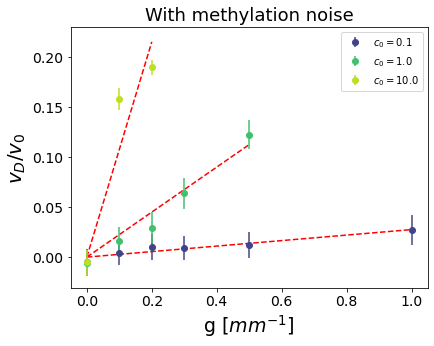

In [28]:
# v_D as a function of gradient and c_0 WITH methylation noise



# rootdir in the form of data_with_metnoise / data_without_metnoisse
# subdirectories : c0=1, c0=0.1, c0=10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5
 
# in each g-directory 120 Main_output_#.txt files from running main.py

colors = plt.cm.viridis([0.2, 0.7, 0.9]) 
conc = np.array([0.1,1, 10])

rootdir = "../code/changing_g_w_metnoise_700s_5ms_v20"
# Filter and sort folders by numerical value after "c0_"
dircmain = sorted(
    [f for f in os.listdir(rootdir) if not f.startswith('.') and f.startswith('c0_')],
    key=lambda name: float(re.search(r'c0_(\d+(?:\.\d+)?)', name).group(1))
)
num_dirc = len(dircmain)

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)
pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
cc = np.array([1, 2, 4])
plt.figure(figsize=(6.4, 4.8))

for dirc in dircmain:
    print(dirc)
    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    gradient_g = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'g([0-9.]+)', dir_name)
            if match:
                g_value = float(match.group(1))
                gradient_g.append(g_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+2])
                    v_x_list.append(data[num_points+2:])

        print('gradients: ', gradient_g)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points-1, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir] / v_0_run
        x = np.array(gradient_g)
        err = std_v[count_dir] / v_0_run
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        y_sorted_with0 = np.concatenate(([0], y_sorted[1:]))

        x_sorted = x[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        err_sorted = err[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted_with0, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)
        # Fit a line through the origin: y = m * x
        m_slope = np.sum(x_sorted * y_sorted) / np.sum(x_sorted**2)

        # Create the fitted line
        y_fit = m_slope * x_sorted

        # plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)
        plt.plot(x_sorted, y_fit, '--r')  # red dashed line (fit only)

        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            color=colors[count_dir],
            label=f"$c_0 = {conc[count_dir]}$"
        )

        count_dir += 1

plt.title(r'With methylation noise', fontsize=18)
plt.xlabel(r'g [$mm^{-1}$]', fontsize=19)
plt.ylabel(r'$v_D/v_0$ ', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(top = 0.23)
plt.legend()
plt.show()

[0.  0.1 0.2 0.3 0.5 1. ]
(140000, 120)
(5501,)
$c_0$ = 0.1
(140000, 120)
(5501,)
$c_0$ = 1.0
(140000, 120)
(5501,)
$c_0$ = 10.0


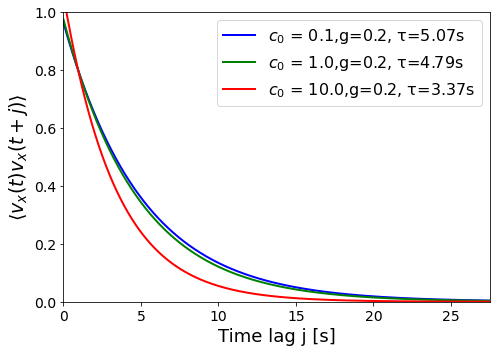

In [30]:
# Autocorrelation of v_x with changing c_0 as well



# make sure to run previous cells to get data

dt_model = 5 * 10**(-3)
gradient_g1 = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 1.0]) # np.array([gradient_g])
print(gradient_g1)
plt.figure(figsize=(7, 5))  # Create a single figure for all plots

colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'black']  # extend as needed
   # Unique color per curve
tau_list = []
color_index = 0
for c_index in range(0,3):
#c_index = 2
# for g_index in range(0,3):

        g_index = 2
        v_x_bin = v_x[c_index][:, :, g_index]  # Shape: (time_points, N_trajectories)
        print(v_x_bin.shape)
        acf_matrix = []

        for i in range(v_x_bin.shape[1]):
            column_data = v_x_bin[:, i]
            acf_values = acf(
                column_data,
                adjusted=True,
                nlags=5500,
                qstat=False,
                fft=True,
                alpha=None,
                bartlett_confint=True,
                missing='none'
            )
            acf_matrix.append(acf_values)

        acf_matrix = np.array(acf_matrix).T
        acf_mean = np.mean(acf_matrix, axis=1)
        print(acf_mean.shape)

        lags = np.arange(len(acf_mean))

        # Fit exponential decay
        try:
            params, _ = curve_fit(exponential_decay, lags, acf_mean, p0=[5, 1])
            tau_autocorr = params[0]
            tau_list.append(tau_autocorr)
            dt_autoc = tau_autocorr*dt_model

            # Plot ACF
            #plt.plot(lags, acf_mean, marker='o', linestyle='-', color=colors[idx], label=f"g={gradient_g[:, g_index][0]}mm-1, τ={dt_autoc:.2f}s")
            # Plot fit
            gg = gradient_g1[g_index] # gradient_g1[:, g_index][0]
            plt.plot(lags*dt_model, exponential_decay(lags, *params), linestyle='-', linewidth=2.0, color=colors[color_index], label=f"$c_0$ = {conc[c_index]},g={gg}, τ={dt_autoc:.2f}s") 
            color_index += 1
            print(f'$c_0$ = {conc[c_index]}') #, g={gg}, τ={dt_autoc:.2f}s')
        except RuntimeError:
            print(f"Fit failed for g_index {g_index}")
            continue

# Final plot formatting
plt.xlabel("Time lag j [s]", fontsize=18)
plt.ylabel(r"$\langle v_x(t)v_x(t+j) \rangle $",fontsize=19)
#plt.title(r"With methylation noise", fontsize=15) # plt.title(r"With methylation noise, $c_0 = 10\ \mu M$", fontsize=15)
plt.xlim([0, max(lags*dt_model)])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim([0, 1])
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

gradient_g2_wm: [0.  0.1 0.2 0.3 0.5 1. ]
Concentrations: [ 0.1  1.  10. ]
Number of concentrations: 3


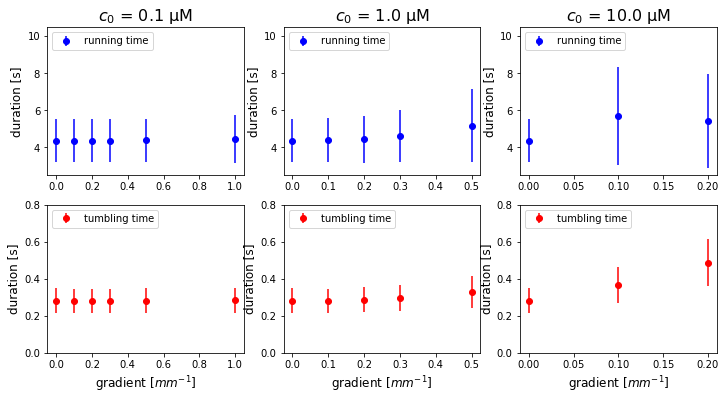

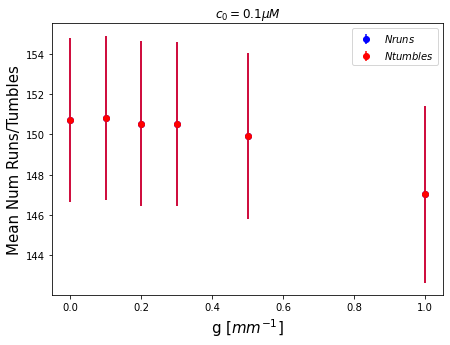

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


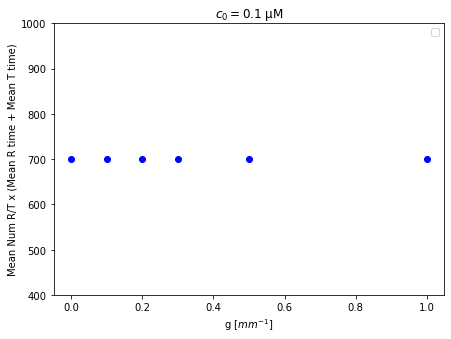

In [34]:
# average run/tumble time as a function of c0 and g



# WITH METHNOISE 
# remember to run previous cells



c0_order_array_wm = np.array(c0_order)
indices_c0_order_sorted_wm = np.argsort(c0_order_array_wm)

gradient_g2_wm = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 1.0])
print("gradient_g2_wm:", gradient_g2_wm)

conc1_wm = c0_order_array_wm
print("Concentrations:", conc1_wm)

dt_model_wm = 0.005  # seconds

N_conc_wm = len(conc1_wm)
print("Number of concentrations:", N_conc_wm)

# Max number of gradients across all vx[c_idx]
N_grad_max_wm = max(v_x[i].shape[2] for i in range(N_conc_wm))
N_traj_wm = v_x[0].shape[1]

N_runs_wm = np.empty(N_conc_wm, dtype=object)
N_tumbles_wm = np.empty(N_conc_wm, dtype=object)

mean_run_time_wm = np.zeros((N_conc_wm, N_grad_max_wm))
mean_tumble_time_wm = np.zeros((N_conc_wm, N_grad_max_wm))

std_run_time_wm = np.zeros((N_conc_wm, N_grad_max_wm))
std_tumble_time_wm = np.zeros((N_conc_wm, N_grad_max_wm))

fig_wm, axes_wm = plt.subplots(2, N_conc_wm, figsize=(12, 3 * 2))
axes_wm = np.reshape(axes_wm, (2, N_conc_wm))

for c_idx_wm in range(N_conc_wm):
    current_N_grad_wm = v_x[c_idx_wm].shape[2]

    N_runs_wm[c_idx_wm] = np.zeros((N_traj_wm, current_N_grad_wm))
    N_tumbles_wm[c_idx_wm] = np.zeros((N_traj_wm, current_N_grad_wm))

    for g_idx_wm in range(current_N_grad_wm):
        array_tumbles_wm = []
        array_runs_wm = []
        var_run_traj_i_wm = []
        var_tumble_traj_i_wm = []

        for traj_idx_wm in range(N_traj_wm):
            zero_count_wm = 0
            non_zero_count_wm = 0
            array_tumbles_traj_i_wm = []
            array_runs_traj_i_wm = []

            for i in v_x[c_idx_wm][:, traj_idx_wm, g_idx_wm]:
                if i == 0:
                    zero_count_wm += 1
                    if non_zero_count_wm > 0:
                        array_runs_wm.append(non_zero_count_wm)
                        array_runs_traj_i_wm.append(non_zero_count_wm)
                        non_zero_count_wm = 0
                else:
                    non_zero_count_wm += 1
                    if zero_count_wm > 0:
                        array_tumbles_wm.append(zero_count_wm)
                        array_tumbles_traj_i_wm.append(zero_count_wm)
                        zero_count_wm = 0

            if zero_count_wm > 0:
                array_tumbles_wm.append(zero_count_wm)
                array_tumbles_traj_i_wm.append(zero_count_wm)
            if non_zero_count_wm > 0:
                array_runs_wm.append(non_zero_count_wm)
                array_runs_traj_i_wm.append(non_zero_count_wm)

            N_runs_wm[c_idx_wm][traj_idx_wm, g_idx_wm] = len(array_runs_traj_i_wm)
            N_tumbles_wm[c_idx_wm][traj_idx_wm, g_idx_wm] = len(array_tumbles_traj_i_wm)

            if N_runs_wm[c_idx_wm][traj_idx_wm, g_idx_wm] - N_tumbles_wm[c_idx_wm][traj_idx_wm, g_idx_wm] != 0:
                if N_runs_wm[c_idx_wm][traj_idx_wm, g_idx_wm] - N_tumbles_wm[c_idx_wm][traj_idx_wm, g_idx_wm] != 1:
                    print('bro smt wrong')
                N_tumbles_wm[c_idx_wm][traj_idx_wm, g_idx_wm] += 1
                array_tumbles_wm.append(1)
                array_tumbles_traj_i_wm.append(1)

            running_times_traj_i_wm = np.array(array_runs_traj_i_wm) * dt_model_wm
            tumbling_times_traj_i_wm = np.array(array_tumbles_traj_i_wm) * dt_model_wm

            var_run_traj_i_wm.append(np.var(running_times_traj_i_wm) / len(running_times_traj_i_wm))
            var_tumble_traj_i_wm.append(np.var(tumbling_times_traj_i_wm) / len(tumbling_times_traj_i_wm))

        var_run_time_wm = np.mean(var_run_traj_i_wm)
        var_tumble_time_wm = np.mean(var_tumble_traj_i_wm)

        tumble_times_wm = np.array(array_tumbles_wm) * dt_model_wm
        run_times_wm = np.array(array_runs_wm) * dt_model_wm

        mean_run_time_wm[c_idx_wm, g_idx_wm] = np.mean(run_times_wm)
        std_run_time_wm[c_idx_wm, g_idx_wm] = np.sqrt(var_run_time_wm)

        mean_tumble_time_wm[c_idx_wm, g_idx_wm] = np.mean(tumble_times_wm)
        std_tumble_time_wm[c_idx_wm, g_idx_wm] = np.sqrt(var_tumble_time_wm)

    # Plotting per concentration
    g_vals_wm = gradient_g2_wm[:current_N_grad_wm]

    axes_wm[0, c_idx_wm].errorbar(
        g_vals_wm,
        mean_run_time_wm[c_idx_wm, :current_N_grad_wm],
        yerr=2 * std_run_time_wm[c_idx_wm, :current_N_grad_wm],
        fmt='o',
        linestyle='none',
        color='b',
        label=f"running time"
    )
    axes_wm[0, c_idx_wm].set_ylabel('duration [s]', fontsize=12)
    axes_wm[0, c_idx_wm].set_title(f"$c_0$ = {conc1_wm[c_idx_wm]} μM", fontsize=16)
    axes_wm[0, c_idx_wm].set_ylim([2.5, 10.5])
    axes_wm[0, c_idx_wm].legend(loc='upper left')

    axes_wm[1, c_idx_wm].errorbar(
        g_vals_wm,
        mean_tumble_time_wm[c_idx_wm, :current_N_grad_wm],
        yerr=2 * std_tumble_time_wm[c_idx_wm, :current_N_grad_wm],
        fmt='o',
        linestyle='none',
        color='r',
        label=f"tumbling time"
    )
    axes_wm[1, c_idx_wm].set_xlabel(r'gradient [$mm^{-1}$]', fontsize=12)
    axes_wm[1, c_idx_wm].set_ylabel('duration [s]', fontsize=12)
    axes_wm[1, c_idx_wm].set_ylim([0, 0.8])
    axes_wm[1, c_idx_wm].legend(loc='upper left')

plt.show()

# --------- Additional plots ---------

c_index_plt_wm = 0
current_N_grad_wm = v_x[c_index_plt_wm].shape[2]

mean_N_runs_wm = np.mean(N_runs_wm[c_index_plt_wm], axis=0)
std_N_runs_wm = np.sqrt(np.var(N_runs_wm[c_index_plt_wm], axis=0) / N_traj_wm)
mean_N_tumbles_wm = np.mean(N_tumbles_wm[c_index_plt_wm], axis=0)
std_N_tumbles_wm = np.sqrt(np.var(N_tumbles_wm[c_index_plt_wm], axis=0) / N_traj_wm)

plt.figure(figsize=(7, 5))
plt.errorbar(gradient_g2_wm[:current_N_grad_wm], mean_N_runs_wm, yerr=2 * std_N_runs_wm, fmt='o',
             linestyle='none', color='b', label=f"$N  runs$")
plt.errorbar(gradient_g2_wm[:current_N_grad_wm], mean_N_tumbles_wm, yerr=2 * std_N_tumbles_wm, fmt='o',
             linestyle='none', color='r', label=f"$N tumbles$")
plt.title(f'$c_0 = {conc1_wm[c_index_plt_wm]} μM$')
plt.ylabel(r'Mean Num Runs/Tumbles', fontsize=15)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=15)
plt.legend()
plt.show()

# Check total time consistency
sum_to_verify_wm = (mean_N_runs_wm[:current_N_grad_wm] * mean_run_time_wm[c_index_plt_wm, :current_N_grad_wm] +
                    mean_N_tumbles_wm[:current_N_grad_wm] * mean_tumble_time_wm[c_index_plt_wm, :current_N_grad_wm])

plt.figure(figsize=(7, 5))
plt.errorbar(gradient_g2_wm[:current_N_grad_wm], sum_to_verify_wm, yerr=0, fmt='o',
             linestyle='none', color='b')
plt.title(f'$c_0 = {conc1_wm[c_index_plt_wm]}$ μM')
plt.ylabel(r'Mean Num R/T x (Mean R time + Mean T time)', fontsize=10)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=10)
plt.ylim([400, 1000])
plt.legend()
plt.show()



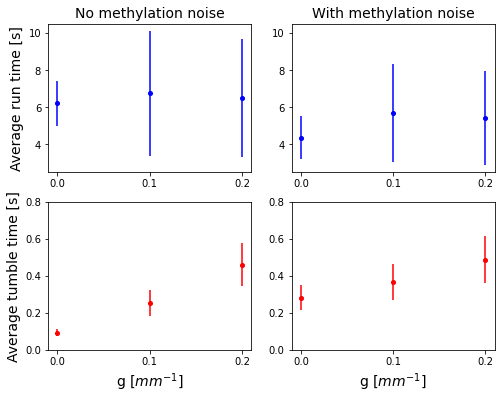

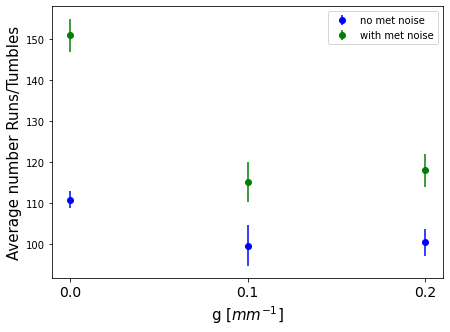

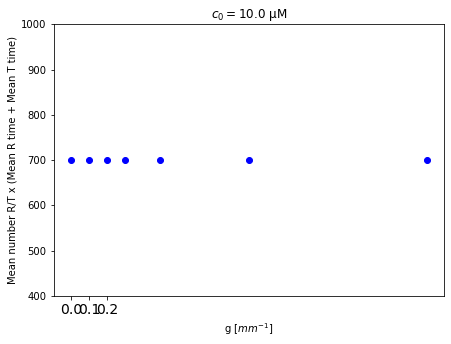

In [43]:
# mean run and tumble duration WITH and WITHOUT methylation noise


c0_idx_toplot = 2 #0 for c_0= 0.1, 1 for c_0 = 1, 2 for c_0 =10

c_idx = c0_idx_toplot
c_idx_wm = c0_idx_toplot
current_N_grad_wm = 3 #6 for c_0= 0.1, 5 for c_0 = 1, 3 for c_0 =10

length_gg = lenght_g_array-4 # for c0=0.1(lenght_g_array-1), for c0=10 lenght_g_array-4 for c0=1(lenght_g_array-2), for c0=10 lenght_g_array-4

fig, axes = plt.subplots(2, 2, figsize=(8, 3 *2))
axes = np.reshape(axes, (2, 2))

axes[0, 0].errorbar(
            gradient_g2[0:length_gg],
            mean_run_time[c_idx, 0:length_gg],
            yerr=2 * std_run_time[c_idx, 0:length_gg], 
            fmt='o',
    markersize=4,
            linestyle='none',
            color='b',
            label=f"running time"
        )
axes[0, 0].set_ylabel('Average run time [s]', fontsize=14)
axes[0, 0].set_title(f"No methylation noise", fontsize=14)
#axes[0, 0].tick_params(axis='both', which='major', labelsize=12)
axes[0, 0].set_ylim([2.5,10.5])
axes[0, 0].set_xticks([0, 0.1, 0.2])
#axes[0, 0].legend(loc='upper left')

axes[1, 0].errorbar(
        gradient_g2[0:length_gg],
        mean_tumble_time[c_idx, 0:length_gg],
        yerr=2 * std_tumble_time[c_idx, 0:length_gg], 
        fmt='o',
    markersize=4,
        linestyle='none',
        color='r',
        label=f"tumbling time"
    )
axes[1, 0].set_xlabel(r'g [$mm^{-1}$]', fontsize=14)
axes[1, 0].set_ylabel('Average tumble time [s]', fontsize=14)
#axes[1, 0].tick_params(axis='both', which='major', labelsize=12)
axes[1, 0].set_ylim([0,0.8])
axes[1, 0].set_xticks([0, 0.1, 0.2])
#axes[1, 0].legend(loc='upper left')


axes[0, 1].errorbar(
    gradient_g2[0:length_gg],
    mean_run_time_wm[c_idx_wm, :current_N_grad_wm],
    yerr=2 * std_run_time_wm[c_idx_wm, :current_N_grad_wm],
    fmt='o',
    markersize=4,
    linestyle='none',
    color='b',
    label=f"running time"
)

axes[0, 1].set_title(f"With methylation noise", fontsize=14)
axes[0, 1].set_ylim([2.5, 10.5])
axes[0, 1].set_xticks([0, 0.1, 0.2])
#axes[0, c_idx_wm].legend(loc='upper left')

axes[1, 1].errorbar(
    gradient_g2[0:length_gg],
    mean_tumble_time_wm[c_idx_wm, :current_N_grad_wm],
    yerr=2 * std_tumble_time_wm[c_idx_wm, :current_N_grad_wm],
    fmt='o',
    markersize=4,
    linestyle='none',
    color='r',
    label=f"tumbling time"
)
axes[1, 1].set_xlabel(r'g [$mm^{-1}$]', fontsize=14)
#axes[1, c_idx_wm].tick_params(axis='both', which='major', labelsize=9)
axes[1, 1].set_ylim([0, 0.8])
axes[1, 1].set_xticks([0, 0.1, 0.2])
#axes[1, c_idx_wm].legend(loc='upper left')

plt.show()





c_index_plt = c0_idx_toplot
mean_N_runs = np.mean(N_runs[c_index_plt], axis = 0)
std_N_runs = np.sqrt(np.var(N_runs[c_index_plt], axis = 0) / N_traj)
mean_N_tumbles = np.mean(N_tumbles[c_index_plt], axis = 0)
std_N_tumbles = np.sqrt(np.var(N_tumbles[c_index_plt], axis = 0) / N_traj)

c_index_plt_wm = c0_idx_toplot
current_N_grad_wm = v_x[c_index_plt_wm].shape[2]

mean_N_runs_wm = np.mean(N_runs_wm[c_index_plt_wm], axis=0)
std_N_runs_wm = np.sqrt(np.var(N_runs_wm[c_index_plt_wm], axis=0) / N_traj_wm)
mean_N_tumbles_wm = np.mean(N_tumbles_wm[c_index_plt_wm], axis=0)
std_N_tumbles_wm = np.sqrt(np.var(N_tumbles_wm[c_index_plt_wm], axis=0) / N_traj_wm)


plt.figure(figsize=(7, 5))

plt.errorbar(gradient_g2[0:length_gg], mean_N_runs[0:length_gg], 
             yerr= 2* std_N_runs[0:length_gg], fmt='o',
            linestyle='none',
            color='b',
            label=f"no met noise"
        )

#plt.title(f'$c_0 = {conc1[c_index_plt]} μM$')
plt.ylabel(r'Mean number Runs/Tumbles', fontsize=1)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=15)

plt.errorbar(gradient_g2[0:length_gg], mean_N_runs_wm[0:length_gg], 
             yerr=2 * std_N_runs_wm[0:length_gg], fmt='o',
             linestyle='none', color='g', label=f"with met noise")

#plt.title(f'$c_0 = {conc1_wm[c_index_plt_wm]} μM$')
plt.ylabel(r'Average number Runs/Tumbles', fontsize=15)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=15)
plt.xticks([0, 0.1, 0.2], fontsize=14)


plt.legend()
plt.show()

 
sum_to_verify = mean_N_runs * mean_run_time[c_index_plt, :].flatten() + mean_N_tumbles * mean_tumble_time[c_index_plt, :].flatten()
#err_sum = 

plt.figure(figsize=(7, 5))

plt.errorbar(gradient_g2, sum_to_verify, yerr= 2* 0, fmt='o',
            linestyle='none',
            color='b'#,
            #label=f"$N  runs$"
        )

plt.title(f'$c_0 = {conc1[c_index_plt]}$ μM')
plt.ylabel(r'Mean number R/T x (Mean R time + Mean T time)', fontsize=10)
plt.xlabel(r'g $[mm^{-1}]$', fontsize=10)
plt.xticks([0, 0.1, 0.2], fontsize=14)
plt.ylim([400, 1000])
#plt.legend()
plt.show()

changing_sigma_r_g0.3_c1_no_metnoise_700s_5ms_v20
sigma_r_1
120
sigma_r_1.5
120
sigma_r_4
120
sigma_r_1.2
120
sigma_r_0.5
120
sigma_r_2
120
sigma_r_5
120
sigma_r_3
120
sigma_r_0.2
120
sigma :  [1.0, 1.5, 4.0, 1.2, 0.5, 2.0, 5.0, 3.0, 0.2]
[-0.00918489  1.80875652]
[1.78725288 1.79820494 1.78154301 1.80708464 1.80478416 1.81780509
 1.82132077 1.73300723 1.75880399] [0.13864333 0.13868679 0.13624365 0.14022726 0.14019049 0.14020837
 0.14096576 0.14578877 0.14531759]
changing_sigma_r_g0.3_c1_w_metnoise_700s_5ms_v20
sigma_r_1.2
120
sigma_r_0.5
120
sigma_r_3
120
sigma_r_2
120
sigma_r_1
120
sigma_r_4
120
sigma_r_0.2
120
sigma_r_1.5
120
sigma_r_5
120
sigma :  [1.2, 0.5, 3.0, 2.0, 1.0, 4.0, 0.2, 1.5, 5.0]
[0.00759437 1.38818863]
[1.42848715 1.43082675 1.27294911 1.3981307  1.40323732 1.44164385
 1.42129684 1.39757625 1.4392862 ] [0.13572604 0.13548126 0.15358748 0.13618111 0.13595705 0.13924156
 0.14088662 0.14391007 0.1414531 ]


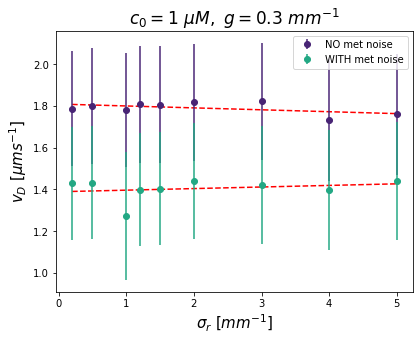

In [3]:
# Changing sigma (counting noise) with and withut met noise, c0 = 1, g= 0.3



colors = plt.cm.viridis([0.1, 0.6, 0.8]) 


rootdir = "../code/changing_sigma_r_c1_g0.3_no&wmetnoise"
dircmain = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dirc = len(dircmain)

label_dir = ["NO met noise", "WITH met noise"]

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)
pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
cc = np.array([0,0,0])# np.array([1, 2, 4])
plt.figure(figsize=(6.4, 4.8))

for dirc, dir_label in zip(dircmain, label_dir):
    print(dirc)
    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    sigma_r = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'r_([0-9.]+)', dir_name)
            if match:
                sigma_value = float(match.group(1))
                sigma_r.append(sigma_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+2])
                    v_x_list.append(data[num_points+2:])

        print('sigma : ', sigma_r)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points-1, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir] / v_0_run
        x = np.array(sigma_r)
        err = std_v[count_dir] / v_0_run
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices][0:(len(sigma_r)-cc[count_dir])]

        x_sorted = x[sorted_indices][0:(len(sigma_r)-cc[count_dir])]
        err_sorted = err[sorted_indices][0:(len(sigma_r)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)

        plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)

        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            color=colors[count_dir],
            label=dir_label
        )
        print(y_sorted, err_sorted)
        count_dir += 1

plt.title(r'$c_0 = 1\ \mu M,\ g = 0.3\ mm^{-1}$', fontsize=17)
plt.xlabel(r'$\sigma_r$ [$mm^{-1}$]', fontsize=15)
plt.ylabel(r'$v_D$ $[\mu m s^{-1}]$', fontsize=15)
plt.legend()
plt.show()